In [14]:
import torch.nn as nn
import torch
from subfunc import data_loader
import random
import matplotlib.pyplot as plt

random.seed(1337)
torch.manual_seed(1337)

In [17]:
x, y, x_val, y_val, x_test, y_test = data_loader()
x = torch.tensor(x)
y = torch.tensor(y)
x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
print("y shape", y.shape)
steps = 100 #400
sample, yoko, tate = x.shape
h1 = 80
h2 = 30
in_shape = yoko*tate
l1 = nn.Linear(in_shape,h1)
# nl1 = nn.LeakyReLU(0.2)
bn1 = nn.BatchNorm1d(h1)
nl1 = nn.ReLU()
# nl1 = nn.Softmax(dim=1)
l2 = nn.Linear(h1, h2)
bn2 = nn.BatchNorm1d(h2)
nl2 = nn.ReLU()
# nl2 = nn.Softmax(dim=1)
outl = nn.Linear(h2, 10)
input_data = torch.reshape(x, (sample, yoko*tate))
sample_val, yoko, tate = x_val.shape
x_val = torch.reshape(x_val, (sample_val, yoko*tate))

# optimizer and loss
params = list(l1.parameters()) + list(l2.parameters()) + list(outl.parameters())
lr=0.0002
optimizer = torch.optim.Adam(params, lr=lr)
loss_fn = nn.CrossEntropyLoss()

y shape torch.Size([60000])


In [18]:
for step in range(steps):

    output1 = l1(input_data)
    output1b = bn1(output1)
    output2 = nl1(output1b)  #non lenear 1
    output3 = l2(output2)
    output3b = bn2(output3)
    output4 = nl2(output3b) #non lenear 2
    output = outl(output4)

    if step == 21:
         lr = lr * 0.4
         for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    if step == 35:
         lr = lr * 0.2
         for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    if step == 200:
         lr = lr * 0.3
         for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    if step == 300:
         lr = lr * 0.3
         for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    loss_output = loss_fn(output, y)
    if step % 10 == 0:
        with torch.no_grad():

            # accuracy 
            preds = torch.argmax(output, dim=1)
            correct = (preds == y).sum().item()
            accuracy = correct / y.size(0)

            # validation
            output_val = l1(x_val)
            output_val = bn1(output_val)
            output_val = nl1(output_val)
            output_val = l2(output_val)
            output_val = bn2(output_val)
            output_val = nl2(output_val)
            output_val = outl(output_val)

            # validation loss
            val_loss = loss_fn(output_val, y_val)

            # calculate validation accuracy
            preds_val = torch.argmax(output_val, dim=1)
            correct_val = (preds_val == y_val).sum().item()
            val_accuracy = correct_val / y_val.size(0)

        print(f"{step:2d} iter -> loss output :{loss_output.item():.4f} | lr: {lr:7f} | Accuracy: {accuracy*100:.2f}%| Val Loss: {val_loss.item():.4f} | Val Acccuracy: {val_accuracy*100:.2f}%")
    
    loss_output.backward()
    optimizer.step()

 0 iter -> loss output :2.3855 | lr: 0.000200 | Accuracy: 11.40%| Val Loss: 2.3908 | Val Acccuracy: 11.98%
10 iter -> loss output :1.8977 | lr: 0.000200 | Accuracy: 37.89%| Val Loss: 1.9324 | Val Acccuracy: 35.78%
20 iter -> loss output :1.6871 | lr: 0.000200 | Accuracy: 55.86%| Val Loss: 1.7201 | Val Acccuracy: 54.84%
30 iter -> loss output :1.6260 | lr: 0.000080 | Accuracy: 60.46%| Val Loss: 1.6598 | Val Acccuracy: 59.84%
40 iter -> loss output :1.5936 | lr: 0.000016 | Accuracy: 62.97%| Val Loss: 1.6283 | Val Acccuracy: 62.06%
50 iter -> loss output :1.5808 | lr: 0.000016 | Accuracy: 63.98%| Val Loss: 1.6159 | Val Acccuracy: 62.90%
60 iter -> loss output :1.5664 | lr: 0.000016 | Accuracy: 65.05%| Val Loss: 1.6019 | Val Acccuracy: 63.86%
70 iter -> loss output :1.5511 | lr: 0.000016 | Accuracy: 66.14%| Val Loss: 1.5870 | Val Acccuracy: 64.94%
80 iter -> loss output :1.5354 | lr: 0.000016 | Accuracy: 67.27%| Val Loss: 1.5716 | Val Acccuracy: 65.76%
90 iter -> loss output :1.5195 | lr: 

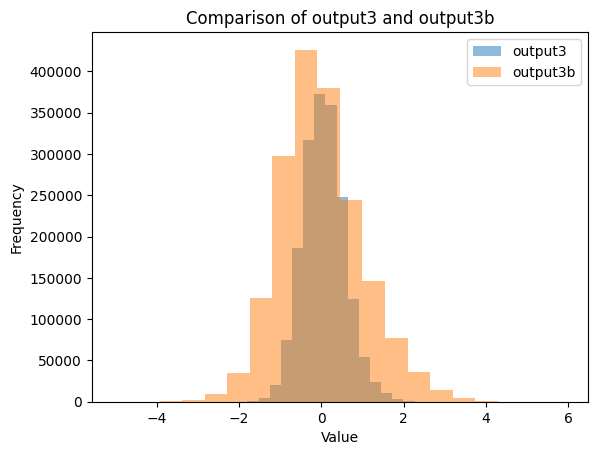

In [28]:
# Assuming output3 and output3b are tensors, you need to flatten them and convert to a list
# output1_flat = output1.view(-1).tolist()
# output1b_flat = output1b.view(-1).tolist()
output3_flat = output3.view(-1).tolist()
output3b_flat = output3b.view(-1).tolist()

# Create the histogram
# plt.hist(output1_flat, bins=20, alpha=0.5, label='output1')
# plt.hist(output1b_flat, bins=20, alpha=0.5, label='output1b')
plt.hist(output3_flat, bins=20, alpha=0.5, label='output3')
plt.hist(output3b_flat, bins=20, alpha=0.5, label='output3b')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Comparison of output3 and output3b')

# Add a legend to differentiate the two histograms
plt.legend()

# Show the plot
plt.show()

### CNN MNIST

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from subfunc import data_loader
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR

class KMIST_CNN(nn.Module):

    def __init__(self, H, W, in_channels, layer_1_channels, layer_2_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, layer_1_channels, kernel_size=3, padding=1)  #output 32 x 28 x 28
        self.bn1 = nn.BatchNorm2d(layer_1_channels)
        self.pool1 = nn.MaxPool2d(2, 2)  #output 32 x 14 x 14

        self.conv2 = nn.Conv2d(layer_1_channels, layer_2_channels, kernel_size=3, padding=1)  #output 64 x 14 x 14
        self.bn2 = nn.BatchNorm2d(layer_2_channels)
        self.pool2 = nn.MaxPool2d(2, 2)  # output 64 x 7 x 7

        self.fc1 = nn.Linear(layer_2_channels * H//4 * W//4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for KMINST
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  #flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [47]:
### PARAMETERS
in_channels = 1
layer_1_channels = 32
layer_2_channels = 64
max_step = 400
b_size = 80

x, y, x_val, y_val, x_test, y_test = data_loader()
# batch, height, width  B = 600000, height = 28, width = 28
B, H, W = x.shape
x = torch.tensor(x)
y = torch.tensor(y)
x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
print(x.shape)
x = x.unsqueeze(in_channels)
x_val = x_val.unsqueeze(in_channels)
print(x.shape)
print(x_val.shape)
# batch, channel, height, width  B = 600000, c = 1, height = 28, width = 28
# channel is the depth of the data, RGB or just gray




torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])
torch.Size([5000, 1, 28, 28])


In [52]:
# training 

model = KMIST_CNN(H, W, in_channels, layer_1_channels, layer_2_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[40, 60, 200, 300], gamma=0.5)
loss_fn = nn.CrossEntropyLoss()



In [53]:
for step in range(max_step):

    # print("step", step)

    if step == 0:
        batch_start = 0
        batch_end = b_size
    else:
        batch_start = step * b_size
        batch_end = (step + 1) * b_size
    
    batch_end = min(batch_end, len(x))
    # print("batch start", batch_start)
    # print("batch_end", batch_end)
    
    x_batch = x[batch_start:batch_end]
    y_batch = y[batch_start:batch_end]

    x_val_batch = x_val[:2000]
    y_val_batch = y_val[:2000]

    # Training step
    model.train()
    logits = model(x_batch)
    loss = loss_fn(logits, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Validation step
    model.eval()
    with torch.no_grad():
        # accuracy 
        preds = torch.argmax(logits, dim=1)
        correct = (preds == y_batch).sum().item()
        accuracy = correct / y_batch.size(0)

        # validation
        val_logits = model(x_val_batch)
        loss_val = loss_fn(val_logits, y_val_batch)

        # val accuracy
        preds_val = torch.argmax(val_logits, dim=1)
        correct_val = (preds_val == y_val_batch).sum().item()
        accuracy_Val = correct_val / y_val_batch.size(0)


    if step % 20 == 0:
        print(f"{step:2d} x-> loss:{loss.item():.4f}| lr: {current_lr:.7f} | Accuracy :{accuracy*100:.2f}% | Val-loss: {loss_val.item():.4f}| Val Accuracy: {accuracy_Val*100:.2f}%")

    

 0 x-> loss:2.4084| lr: 0.0010000 | Accuracy :3.75% | Val-loss: 2.7739| Val Accuracy: 9.15%
20 x-> loss:0.8100| lr: 0.0010000 | Accuracy :75.00% | Val-loss: 0.6961| Val Accuracy: 81.10%
40 x-> loss:0.6115| lr: 0.0005000 | Accuracy :77.50% | Val-loss: 0.4134| Val Accuracy: 88.55%
60 x-> loss:0.4904| lr: 0.0002500 | Accuracy :83.75% | Val-loss: 0.3135| Val Accuracy: 92.10%
80 x-> loss:0.5062| lr: 0.0002500 | Accuracy :87.50% | Val-loss: 0.2984| Val Accuracy: 91.75%
100 x-> loss:0.2786| lr: 0.0002500 | Accuracy :93.75% | Val-loss: 0.2728| Val Accuracy: 92.45%
120 x-> loss:0.3946| lr: 0.0002500 | Accuracy :87.50% | Val-loss: 0.2569| Val Accuracy: 93.10%
140 x-> loss:0.3385| lr: 0.0002500 | Accuracy :95.00% | Val-loss: 0.2515| Val Accuracy: 92.80%
160 x-> loss:0.2282| lr: 0.0002500 | Accuracy :95.00% | Val-loss: 0.2241| Val Accuracy: 94.00%
180 x-> loss:0.2142| lr: 0.0002500 | Accuracy :96.25% | Val-loss: 0.2056| Val Accuracy: 94.20%
200 x-> loss:0.3974| lr: 0.0001250 | Accuracy :87.50% | V

### GENERAL NEURALNET

In [87]:
import torch.nn as nn
import torch
from subfunc import data_loader
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F 

random.seed(1337)
torch.manual_seed(1337)

In [97]:
x, y, x_val, y_val, x_test, y_test = data_loader()
x = torch.tensor(x)
y = torch.tensor(y)
x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)
print("y shape", y.shape)
steps = 300

B, W, H = x.shape
input_data = torch.reshape(x, (B, W*H))
b_val, W, H = x_val.shape
input_x_val = torch.reshape(x_val, (b_val, W*H))

y shape torch.Size([60000])


In [98]:


class MNIST_MDL(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 30)
        self.bn1 = nn.BatchNorm1d(30)
        self.nl1 = nn.ReLU()
        self.linear2 = nn.Linear(30, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.nl2 = nn.ReLU()
        self.outln = nn.Linear(20, 10)

    def forward(self, x):
        x = self.nl1(self.bn1(self.linear1(x)))
        x = self.nl2(self.bn2(self.linear2(x)))
        x = self.outln(x)
        return x
    


In [99]:
model = MNIST_MDL()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [100]:
for step in range(steps):

    model.train()
    logits = model(input_data)
    loss_output = loss_fn(logits, y)
    optimizer.zero_grad()
    loss_output.backward()
    optimizer.step()
    lr = optimizer.param_groups[0]['lr']

    model.eval()
    with torch.no_grad():

        # accuracy
        preds = torch.argmax(logits, dim=1)
        correct = (preds == y).sum().item()
        accuracy = correct / y.size(0)

        # validation
        logits_val = model(input_x_val)
        val_loss = loss_fn(logits_val, y_val)
        preds_val = torch.argmax(logits_val, dim=1)
        correct_val = (preds_val == y_val).sum().item()
        val_accuracy = correct_val / y_val.size(0)



    print(f"{step:2d} iter -> loss output :{loss_output.item():.4f} | lr: {lr:7f} | Accuracy: {accuracy*100:.2f}%| Val Loss: {val_loss.item():.4f} | Val Acccuracy: {val_accuracy*100:.2f}%")
    


 0 iter -> loss output :2.3846 | lr: 0.010000 | Accuracy: 9.34%| Val Loss: 1.9091 | Val Acccuracy: 35.50%
 1 iter -> loss output :1.9214 | lr: 0.010000 | Accuracy: 41.39%| Val Loss: 1.6055 | Val Acccuracy: 50.50%
 2 iter -> loss output :1.7594 | lr: 0.010000 | Accuracy: 58.04%| Val Loss: 1.5683 | Val Acccuracy: 56.68%
 3 iter -> loss output :1.6553 | lr: 0.010000 | Accuracy: 66.01%| Val Loss: 1.5324 | Val Acccuracy: 61.90%
 4 iter -> loss output :1.5679 | lr: 0.010000 | Accuracy: 70.91%| Val Loss: 1.4842 | Val Acccuracy: 65.82%
 5 iter -> loss output :1.4874 | lr: 0.010000 | Accuracy: 73.82%| Val Loss: 1.4275 | Val Acccuracy: 68.52%
 6 iter -> loss output :1.4104 | lr: 0.010000 | Accuracy: 75.69%| Val Loss: 1.3662 | Val Acccuracy: 70.04%
 7 iter -> loss output :1.3361 | lr: 0.010000 | Accuracy: 76.98%| Val Loss: 1.3035 | Val Acccuracy: 71.34%
 8 iter -> loss output :1.2645 | lr: 0.010000 | Accuracy: 78.00%| Val Loss: 1.2410 | Val Acccuracy: 72.56%
 9 iter -> loss output :1.1959 | lr: 0

In [2]:
import numpy as np

arr = np.array([1, 5, 2, 8, 3])
max_index = np.argmax(arr)
print(max_index)  # Output: 3
max_value = arr[max_index]
print(max_value) 

3
8


In [9]:
arr_2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
max_index_axis0 = np.argmax(arr_2d, axis=0)
print(max_index_axis0)  # Output: [2 2 2]
arr_value = arr_2d[max_index_axis0]
print(arr_value)

arr_2d2 = np.array([
    [1, 5, 3],
    [6, 4, 2],
    [0, 1, 7]
])


max_index_axis1 = np.argmax(arr_2d2, axis=1)
print(max_index_axis1)  # Output: [2 2 2]
arr_value2 = arr_2d2[max_index_axis1]
print(arr_value2)


[2 2 2]
[[7 8 9]
 [7 8 9]
 [7 8 9]]
[1 0 2]
[[6 4 2]
 [1 5 3]
 [0 1 7]]
